## Inference and Validation
Now that you have a trained network, you can use it for making predictions. This is typically called inference, a term borrowed from statistics. However, neural networks have a tendency to perform too well on the training data and aren't able to generalize to data that hasn't been seen before. This is called overfitting and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the validation set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch.

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting train=False here:

`testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)`

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# better to use all datafor the testloader as batch_size, since it won't be used for training and only for validation 
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13927008.31it/s]                             


Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 95028.17it/s]                            
0it [00:00, ?it/s]

Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3937956.87it/s]                             
0it [00:00, ?it/s]

Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 32302.22it/s]            


Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Here I'll create a model like normal, using the same one from my solution for part 4.

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are precision and recall) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([10000, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the $k$ highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index. (dim=1: across rows and dim=0: across columns). Works on any tensor 

In [4]:
top_ps, top_cls = ps.topk(1, dim=1)
# look at forst 10 only
print(top_cls[:10])

tensor([[1],
        [1],
        [1],
        [6],
        [8],
        [9],
        [6],
        [8],
        [1],
        [1]])


In [5]:
#equals = top_cls.numpy().squeeze() == labels.numpy()
equals = top_cls.view(-1) == labels

Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (64, 1) while labels is 1D with shape (64). To get the equality to work out the way we want, top_class and labels must have the same shape.

If we do

`equals = top_class == labels`

equals will have shape (64, 64), try it yourself. What it's doing is comparing the one element in each row of top_class with each element in labels which returns 64 True/False boolean values for each row.

Now we need to calculate the percentage of correct predictions. equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean. If only it was that simple. If you try torch.mean(equals), you'll get an error

`RuntimeError: mean is not implemented for type torch.ByteTensor`

This happens because equals has type torch.ByteTensor but torch.mean isn't implemented for tensors with that type. So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().

To convert a tensor use tensor.type(torch.tensor_type)

In [6]:
#accuracy = np.mean(equals)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 7.11%


Better to convert the tesors to numpy array during Inference.

The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using torch.no_grad():

# turn off gradients

`with torch.no_grad():`
    `# validation pass here`
    `for images, labels in testloader:`
        `...`
        
>Exercise: Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    running_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    train_loss = running_train_loss/len(trainloader)
    train_losses.append(train_loss)
    
    test_loss = 0
    with torch.no_grad(): # keep the context manager here, so it doesn't get called each time 
        for images, labels in testloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            test_loss += loss.item()
            test_losses.append(loss.item())
            
            top_ps, top_cls = torch.exp(log_ps).topk(1, dim=1)
            accuracy = np.mean(top_cls.numpy().squeeze() == labels.numpy())
            
    print(f'Epoch: {e}\
    Train_Loss: {train_loss:.2f}\
    Test_Loss: {test_loss:.2f}\
    Test_Accuracy {accuracy*100:.2f}')    

Epoch: 0    Train_Loss: 0.52    Test_Loss: 0.43    Test_Accuracy 84.49
Epoch: 1    Train_Loss: 0.39    Test_Loss: 0.40    Test_Accuracy 85.32
Epoch: 2    Train_Loss: 0.36    Test_Loss: 0.41    Test_Accuracy 84.39
Epoch: 3    Train_Loss: 0.34    Test_Loss: 0.37    Test_Accuracy 86.79
Epoch: 4    Train_Loss: 0.32    Test_Loss: 0.38    Test_Accuracy 86.79
Epoch: 5    Train_Loss: 0.30    Test_Loss: 0.37    Test_Accuracy 86.73
Epoch: 6    Train_Loss: 0.29    Test_Loss: 0.37    Test_Accuracy 87.39
Epoch: 7    Train_Loss: 0.28    Test_Loss: 0.38    Test_Accuracy 87.16
Epoch: 8    Train_Loss: 0.27    Test_Loss: 0.36    Test_Accuracy 87.63
Epoch: 9    Train_Loss: 0.27    Test_Loss: 0.37    Test_Accuracy 87.80
Epoch: 10    Train_Loss: 0.26    Test_Loss: 0.38    Test_Accuracy 87.36
Epoch: 11    Train_Loss: 0.25    Test_Loss: 0.39    Test_Accuracy 86.51
Epoch: 12    Train_Loss: 0.25    Test_Loss: 0.37    Test_Accuracy 88.04
Epoch: 13    Train_Loss: 0.24    Test_Loss: 0.38    Test_Accuracy 87.84
Ep

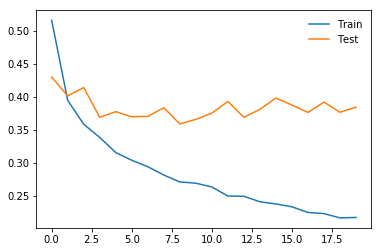

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend(frameon=False);

## Overfitting
If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called early-stopping. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the nn.Dropout module.



`class Classifier(nn.Module):`
    `def __init__(self):`
       `super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)`

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    `def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x`

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use model.eval(). This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with model.train(). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

# turn off gradients
`with torch.no_grad():

    # set model to evaluation mode
    model.eval()

    # validation pass here
    for images, labels in testloader:
        ...`

# set model back to train mode
model.train()
>Exercise: Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # dropout with probability of 20%
        self.dropout = nn.Dropout(p=0.2) 
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x))) # add the dropout to the outputs units of a layer
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return F.log_softmax(self.fc4(x), dim=1)

### Train Functions

In [10]:
def train(model, criterion, optimizer,tr_loader, val_loader, epochs):
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_train_loss = 0
        for images, labels in tr_loader:
            model.train() # turn on dropout with some defined probability
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss/len(tr_loader)
        train_losses.append(train_loss)

        test_loss = 0
        with torch.no_grad(): # keep the context manager here, so it doesn't get called each time 
            model.eval()
            for images, labels in val_loader:
                 # turn off dropout with probability of 0
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()
                test_losses.append(loss.item())

                top_ps, top_cls = torch.exp(log_ps).topk(1, dim=1)
                accuracy = np.mean(top_cls.numpy().squeeze() == labels.numpy())

        print(f'Epoch: {e}\
        Train_Loss: {train_loss:.2f}\
        Test_Loss: {test_loss:.2f}\
        Test_Accuracy {accuracy*100:.2f}')    
    return train_losses, test_losses

def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend(frameon=False)

Epoch: 0        Train_Loss: 0.60        Test_Loss: 0.47        Test_Accuracy 83.03
Epoch: 1        Train_Loss: 0.49        Test_Loss: 0.45        Test_Accuracy 83.93
Epoch: 2        Train_Loss: 0.45        Test_Loss: 0.41        Test_Accuracy 85.19
Epoch: 3        Train_Loss: 0.43        Test_Loss: 0.43        Test_Accuracy 84.44
Epoch: 4        Train_Loss: 0.42        Test_Loss: 0.41        Test_Accuracy 85.23
Epoch: 5        Train_Loss: 0.42        Test_Loss: 0.40        Test_Accuracy 85.90
Epoch: 6        Train_Loss: 0.41        Test_Loss: 0.39        Test_Accuracy 86.17
Epoch: 7        Train_Loss: 0.40        Test_Loss: 0.38        Test_Accuracy 86.66
Epoch: 8        Train_Loss: 0.39        Test_Loss: 0.40        Test_Accuracy 86.17
Epoch: 9        Train_Loss: 0.38        Test_Loss: 0.41        Test_Accuracy 85.69
Epoch: 10        Train_Loss: 0.39        Test_Loss: 0.39        Test_Accuracy 86.38
Epoch: 11        Train_Loss: 0.38        Test_Loss: 0.37        Test_Accuracy 87.09
Ep

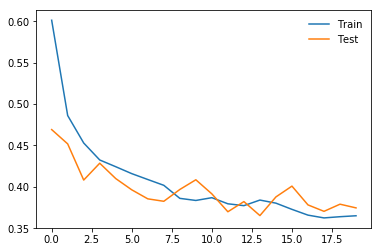

In [11]:
epochs = 20
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# model training
train_losses, test_losses = train(model, criterion, optimizer, trainloader, testloader, epochs)

# plot the losses 
plot_losses(train_losses, test_losses)

### Testing

In [12]:
# testing functions
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

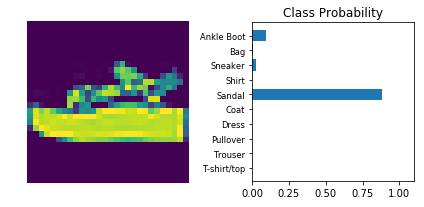

In [13]:
images, labels = next(iter(testloader))
img = images[0]

with torch.no_grad(): # turn off gradients
    model.eval() # turn off drop_out
    ps = torch.exp(model(img))

view_classify(img, ps, version='Fashion')